# Using information theory to evaluate features

The mutual information (MI) between a feature and the outcome is a measure of the mutual dependence between the two variables. It extends the notion of correlation to nonlinear relationships. More specifically, it quantifies the information obtained about one random variable through the other random variable.

The concept of MI is closely related to the fundamental notion of entropy of a random variable. Entropy quantifies the amount of information contained in a random variable. Formally, the mutual information—I(X, Y)—of two random variables, X and Y, is defined as the following:

The sklearn function implements feature_selection.mutual_info_regression that computes the mutual information between all features and a continuous outcome to select the features that are most likely to contain predictive information. There is also a classification version (see the documentation for more details). 

This notebook contains an application to the financial data we created in Chapter 4, Alpha Factor Research.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

We use the data produced in [Chapter 4](../../04_alpha_factor_research/00_data/feature_engineering.ipynb).


In [4]:
with pd.HDFStore('/media/n1c0/SanDiskSSD/assets.h5') as store:
    data = store['engineered_features']

## Create Dummy variables

In [5]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              358914 non-null  float64
 1   return_2m              358914 non-null  float64
 2   return_3m              358914 non-null  float64
 3   return_6m              358914 non-null  float64
 4   return_9m              358914 non-null  float64
 5   return_12m             358914 non-null  float64
 6   Mkt-RF                 358914 non-null  float64
 7   SMB                    358914 non-null  float64
 8   HML                    358914 non-null  float64
 9   RMW                    358914 non-null  float64
 10  CMA                    358914 non-null  float64
 11  momentum_2             358914 non-null  float64
 12  momentum_3             358914 non-null  float64
 13  momentum_6     

## Mutual Information

### Original Data

In [6]:
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
targets = data.dropna().loc[:, target_labels]

features = data.dropna().drop(target_labels, axis=1)
features.sector = pd.factorize(features.sector)[0]

cat_cols = ['year', 'month', 'msize', 'age', 'sector']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [7]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [8]:
mutual_info.sum()

target_1m     0.034722
target_2m     0.061312
target_3m     0.090488
target_6m     0.135531
target_12m    0.199164
dtype: float64

### Normalized MI Heatmap

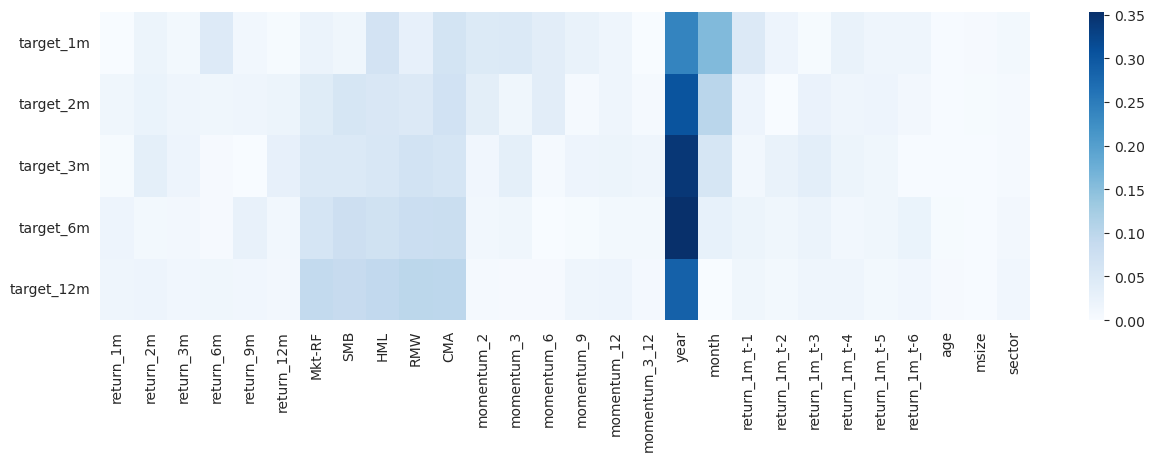

In [9]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

### Dummy Data

In [10]:
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [12]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [13]:
mutual_info_dummies.sum()

target_1m     0.035863
target_2m     0.063242
target_3m     0.093194
target_6m     0.139504
target_12m    0.203897
dtype: float64

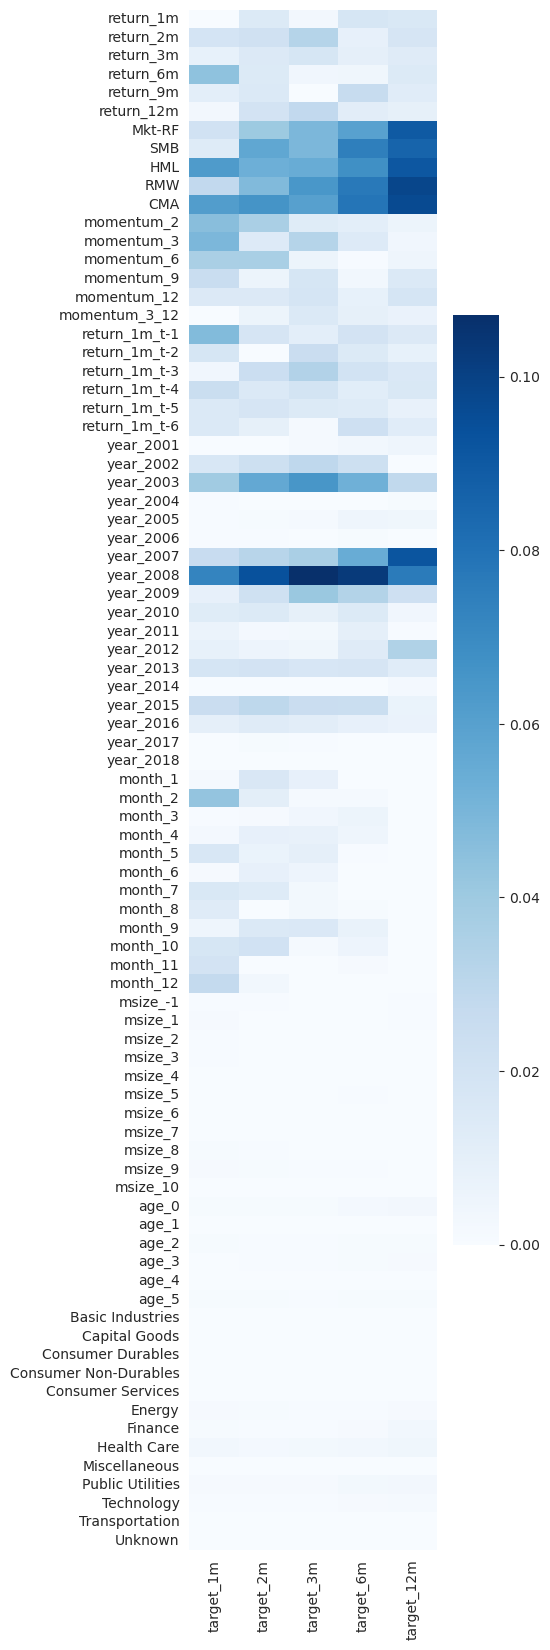

In [14]:
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');